This Notebook trains and evaluates (with CV) a Bag-of-words TF-IDF logistic regression model. Additional features, polarity, subjectivity and incongruity are added.

Group:16

In [0]:
import sys
import time
import os
import math
import copy
import string
import re
from IPython.display import clear_output
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

In [0]:
# utilising the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
%%shell
curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
unzip -q -o -d /tmp /tmp/trainDevTestTrees_PTB.zip
rm -f /tmp/trainDevTestTrees_PTB.zip

In [0]:
# https://stackoverflow.com/questions/55444572/how-does-i-unzip-pretrained-word2vec-in-google-colab
start_time = time.time()
!wget -P /tmp/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
elapsed_time = time.time() - start_time
print('Downloading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

--2020-03-26 15:09:35--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.76.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.76.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/tmp/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  67.0MB/s    in 23s     

2020-03-26 15:09:59 (68.3 MB/s) - ‘/tmp/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
# Load Google's pre-trained Word2Vec model.
start_time = time.time()
word2Vec_filePath = '/tmp/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(word2Vec_filePath, binary=True)
!rm -f word2Vec_filePath
elapsed_time = time.time() - start_time
print('Loading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loading the pre-trained Word2Vec model took 108 seconds


### Cleaning the Sentences

Split data into sentences and labels

In [0]:
from google.colab import drive, files
drive.mount('/content/gdrive')

In [0]:
filepath = "gdrive/My Drive/ted_training_pairs_NLTK2.csv"

data = pd.read_csv(filepath)

sentences = data['text'].values
labels = data['label'].values

In [0]:
labels[0]

'laughter'

Remove punctuation from each sentence

In [0]:
#Create list of all punctuation in the text
punctuation = []
for p in string.punctuation:
    punctuation.append(p)
punctuation.append("''")
punctuation.append("--")
punctuation.append("##")
punctuation.append("``")

In [0]:
new_sentences = []
for sentence in sentences:
    words = sentence.split()
    no_punc_words = [words[i] for i in range(len(words)) if words[i] not in punctuation]
    new_sentences.append(" ".join(no_punc_words))

Creat a dictionary of the vocabulary in order of most frequent words

In [0]:
from collections import Counter

all_text = ' '.join(new_sentences)
words = all_text.split()

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

This is where we start with BoW/ TfIdf model

In [0]:
# Only keep words that appear more than once
processed_corpus = [[token for token in text.split() if count_words[token] > 1] for text in new_sentences]


In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# create model
vect_word = TfidfVectorizer(max_features=2000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)

In [0]:
tr_vect = vect_word.fit_transform(sentences)#apply model

In [0]:
# transform to pytorch Tensor via sparse matrix
coo = tr_vect.tocoo()
values = coo.data
indices = np.vstack((coo.row, coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape

encoded  = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()

In [0]:
encoded.size()

torch.Size([17466, 2000])

Adding polarity and subjectivity

In [0]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

In [0]:
spol = (torch.FloatTensor(data['text'].apply(pol).values).unsqueeze(1) + 1.)/2.
ssub = torch.FloatTensor(data['text'].apply(sub).values).unsqueeze(1)

Adding Incongruity

In [0]:

def get_incongruity_scores(sentence):
  min_similarity = 1
  for word1 in sentence:
      for word2 in sentence:
        if word1 != word2:
          try:
            similarity = model.similarity(word1, word2)
            if similarity < min_similarity:
              min_similarity = similarity
          except Exception:
            pass
  max_similarity = -1
  for word1 in sentence:
      for word2 in sentence:
        if word1 != word2:
          try:
            similarity = model.similarity(word1, word2)
            if similarity > max_similarity:
              max_similarity = similarity
          except Exception:
            pass

  if min_similarity == 1:
    min_similarity == 0
  if max_similarity == -1:
    max_similarity == 0
  
  return min_similarity, max_similarity

In [0]:
sincro = [get_incongruity_scores(x) for x in processed_corpus]# get incongruity scores for each sentence

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
sincro1 = (np.array([*sincro]) +1)/2 # normalise scores to [0,1]

In [0]:
encoded2 = torch.cat([encoded,spol,ssub,torch.FloatTensor(sincro1)],1) # concatenate together

Now we will tokenize the labels

In [0]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
labels_enc = enc.fit_transform(labels)

In [0]:
labels_enc[0]

0

In [0]:
indices = list(range(encoded.shape[0]))

We will now design the Logistic Regression model

In [0]:
### Linear Model for TfIDf where embeddings are precomputed and are fed in as vectors so no need for embeddings layer in model
### note that a number of the inputs are not necessary. This is just for compatibility with other models.
class LR(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
            
        return self.fc(text)

Function to train the model

In [0]:
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix

def binary_accuracy(preds, y):

    #round predictions to the closest integer
    probs = torch.sigmoid(preds)
    rounded_preds = torch.round(probs)
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)

    return acc

In [0]:


def train(model, iterator, optimizer, criterion):
    # model training function - performs one epoch
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_auc = 0
    pred_probs = np.array([])
    preds      = np.array([])
    labs = np.array([])
    model.train()
    
    for text, labels in iterator:
        
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        # forward
        predictions = model(text).squeeze(1)
        
        loss = criterion(predictions, labels)
        
        acc = binary_accuracy(predictions, labels)
        # collect probabilities and predictions
        pred_prob = torch.sigmoid(predictions)
        pred_probs = np.append(pred_probs, pred_prob.detach().cpu())
        pred = torch.round(pred_prob)
        preds = np.append(preds, pred.detach().cpu())
        labs = np.append(labs,labels.detach().cpu())
        # backward
        loss.backward()
        # optimise
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    #f1 
    f1 =  f1_score(labs,preds)
    #auc
    auc = roc_auc_score(labs,pred_probs) 
    # return metrics for epoch    
    return epoch_loss/len(iterator) , epoch_acc / len(iterator), f1, auc

def evaluate(model, iterator, criterion):
    # evaluate of test data. same as train but without model updating
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_auc = 0
    pred_probs = np.array([])
    preds      = np.array([])
    labs = np.array([])
    model.eval()
    
    with torch.no_grad():
    
        for text, labels in iterator:
            
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)
            
            loss = criterion(predictions, labels)
            
            acc = binary_accuracy(predictions, labels)

            pred_prob = torch.sigmoid(predictions)
            pred_probs = np.append(pred_probs, pred_prob.detach().cpu())
            pred = torch.round(pred_prob)
            preds = np.append(preds, pred.detach().cpu())
            labs = np.append(labs,labels.detach().cpu())

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    #f1
    f1 =  f1_score(labs,preds)
    #auc 
    auc = roc_auc_score(labs,pred_probs)    
    return epoch_loss/len(iterator) , epoch_acc / len(iterator), f1, auc, preds


In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Helper function to make plots of the loss and accuracy on the training set and validation set

In [0]:
def plot_loss_accuracy(train_loss, valid_loss, train_acc, valid_acc):
    #plots the loss and accuracy of training and validation set during training
    # comment out to suppress plot output
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss, 'b')
    ax1.plot(valid_loss, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    ax1.legend(['Train', 'Validation'])  
    
    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(train_acc, 'b')
    ax1.plot(valid_acc, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ltrain = np.array(train_loss)  
    least_train_epoch = np.argmin(ltrain)
    least_train_loss = min(train_loss)
    print('Lowest training loss:',least_train_loss,'achieved at epoch:',least_train_epoch)
    
    lval = np.array(valid_loss)  
    least_val_epoch = np.argmin(lval)
    least_val_loss = min(valid_loss)
    print('Lowest validation loss:',least_val_loss,'achieved at epoch:',least_val_epoch)
    
    atrain = np.array(train_acc)  
    best_train_epoch = np.argmax(atrain)
    best_train_accuracy = max(train_acc)
    print('Best training accuracy:',best_train_accuracy * 100,'achieved at epoch:',best_train_epoch)
    aval = np.array(valid_acc)  
    best_val_epoch = np.argmax(aval)
    best_val_accuracy = max(valid_acc)
    print('Best validation accuracy:',best_val_accuracy*100,'achieved at epoch:',best_val_epoch,'\n')
    
    return least_train_loss, least_val_loss, best_train_accuracy, best_val_accuracy

Grid Search

In [0]:
EMBEDDING_DIM = encoded2.shape[1]
N_FILTERS = 100 #<- not applicable but necessary 
N_FILTERS_list = [50, 100, 150] #<- not applicable but necessary 
FILTER_SIZES = [3,4,5] #<- not applicable but necessary 
FILTER_SIZES_list = [[3, 4, 5], [2, 3, 4]] #<- not applicable but necessary 
OUTPUT_DIM = 1
DROPOUT_list = [0.3, 0.5, 0.7] #<- not applicable but necessary 
DROPOUT = 0.5 #<- not applicable but necessary 
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [25,50]
best_valid_loss = float('inf')
from sklearn.model_selection import StratifiedKFold

# Here is where we implement the CV

skf1 = StratifiedKFold(5)

# averages over the test set
test_loss_avg = []
test_acc_avg = []
test_auc_avg = []
test_f1_avg = []


train_loss_avg = []
train_acc_avg = []
train_auc_avg = []
train_f1_avg = []

conf_matrices = []
#  CV over 5 train test splits
for train_indices_m, test_indices in skf1.split(indices,labels_enc):

  
  

  skf2 = StratifiedKFold(5)
  # averages over train and validation splits
  train_losses_avg = np.zeros((len(batch_sizes),len(learning_rates)))
  train_accs_avg = np.zeros((len(batch_sizes),len(learning_rates)))
  train_aucs_avg = np.zeros((len(batch_sizes),len(learning_rates)))
  train_f1s_avg = np.zeros((len(batch_sizes),len(learning_rates)))

  train_losses_std = np.zeros((len(batch_sizes),len(learning_rates)))
  train_accs_std = np.zeros((len(batch_sizes),len(learning_rates)))
  train_aucs_std = np.zeros((len(batch_sizes),len(learning_rates)))
  train_f1s_std = np.zeros((len(batch_sizes),len(learning_rates)))


  val_losses_avg = np.zeros((len(batch_sizes),len(learning_rates)))
  val_accs_avg = np.zeros((len(batch_sizes),len(learning_rates)))
  val_aucs_avg = np.zeros((len(batch_sizes),len(learning_rates)))
  val_f1s_avg = np.zeros((len(batch_sizes),len(learning_rates)))

  val_losses_std = np.zeros((len(batch_sizes),len(learning_rates)))
  val_accs_std = np.zeros((len(batch_sizes),len(learning_rates)))
  val_aucs_std = np.zeros((len(batch_sizes),len(learning_rates)))
  val_f1s_std = np.zeros((len(batch_sizes),len(learning_rates)))


  # grid search over params
  for i,batch_size in enumerate(batch_sizes):

    for j,lr in enumerate(learning_rates):
      
      # losses will be averaged
      train_losses = []
      train_accs = []
      train_f1s = []
      train_aucs = []

      val_losses = []
      val_accs = []
      val_f1s = []
      val_aucs = []

      # CV for each parameter combination
      for train_indices,val_indices in skf2.split(train_indices_m,labels_enc[train_indices_m]):


        # now split train and test
        X_train = encoded2[train_indices]
        y_train = labels_enc[train_indices]

        X_val = encoded2[val_indices]
        y_val = labels_enc[val_indices]

        # create Tensor datasets as usual
        train_data = TensorDataset(X_train, torch.from_numpy(y_train).type(torch.FloatTensor))
        valid_data = TensorDataset(X_val, torch.from_numpy(y_val).type(torch.FloatTensor))
        
        # dataloaders
        
        # make sure to SHUFFLE your data
        train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = False)
        valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last = False)
        
        # instantiate model
        model = LR(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT).to(device)

        # loss function - using cross entropy loss
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr= lr)

        N_EPOCHS = 12

        e_train_loss = np.inf
        e_train_acc = 0
        e_train_f1 = 0
        e_train_auc = 0
        
        e_valid_loss = np.inf
        e_valid_acc = 0
        e_valid_f1 = 0
        e_valid_auc = 0

        for epoch in range(N_EPOCHS): # train for N epochs

          start_time = time.time()
          
          train_loss, train_acc, train_f1, train_auc = train(model, train_loader, optimizer, criterion)
          valid_loss, valid_acc, valid_f1, valid_auc,_ = evaluate(model, valid_loader, criterion)
          
          if valid_acc > e_valid_acc:
            e_train_loss = train_loss
            e_train_acc = train_acc
            e_train_f1 = train_f1
            e_train_auc = train_auc
            
            e_valid_loss = valid_loss
            e_valid_acc = valid_acc
            e_valid_f1 = valid_f1
            e_valid_auc = valid_auc
          
          
          end_time = time.time()

          epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
          print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
          print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
          print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        clear_output(True)
        # save best epoch metrics for averaging
        train_losses.append(e_train_loss)
        train_accs.append(e_train_acc)
        train_f1s.append(e_train_f1)
        train_aucs.append(e_train_auc)
        
        val_losses.append(e_valid_loss)
        val_accs.append(e_valid_acc)
        val_f1s.append(e_valid_f1)
        val_aucs.append(e_valid_auc)
      # average best metrics for each parameter combination
      train_losses_avg[i,j] = np.array(train_losses).mean()
      train_accs_avg[i,j] = np.array(train_accs).mean()
      train_aucs_avg[i,j] = np.array(train_aucs).mean()
      train_f1s_avg[i,j] = np.array(train_f1s).mean()

      train_losses_std[i,j] = np.array(train_losses).std()
      train_accs_std[i,j] = np.array(train_accs).std()
      train_aucs_std[i,j] = np.array(train_aucs).std()
      train_f1s_std[i,j] = np.array(train_f1s).std()


      val_losses_avg[i,j] = np.array(train_losses).mean()
      val_accs_avg[i,j] = np.array(train_accs).mean()
      val_aucs_avg[i,j] = np.array(train_aucs).mean()
      val_f1s_avg[i,j] = np.array(train_f1s).mean()

      val_losses_std[i,j] = np.array(train_losses).std()
      val_accs_std[i,j] = np.array(train_accs).std()
      val_aucs_std[i,j] = np.array(train_aucs).std()
      val_f1s_std[i,j] = np.array(train_f1s).std()

  # find best parameter combination
  i,j = np.unravel_index(np.argmin(val_losses_avg),val_losses_avg.shape)
  best_batch = batch_sizes[i]
  best_lr = learning_rates[j]
  # instantiate new model
  model = LR(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT).to(device)

  # loss function - using cross entropy loss
  criterion = nn.BCEWithLogitsLoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr= best_lr)
  # new train val split
  train_indices, valid_indices = train_test_split(train_indices_m, test_size = 0.2, shuffle = True)  

  X_train = encoded2[train_indices]
  y_train = labels_enc[train_indices]

  X_val = encoded2[valid_indices]
  y_val = labels_enc[valid_indices]
  # create test set here too
  X_test = encoded2[test_indices]
  y_test = labels_enc[test_indices]

  train_data = TensorDataset(X_train, torch.from_numpy(y_train).type(torch.FloatTensor))
  valid_data = TensorDataset(X_val, torch.from_numpy(y_val).type(torch.FloatTensor))
  test_data = TensorDataset(X_test, torch.from_numpy(y_test).type(torch.FloatTensor))

  train_loader = DataLoader(train_data, shuffle=True, batch_size=best_batch, drop_last = False)
  valid_loader = DataLoader(valid_data, shuffle=True, batch_size=best_batch, drop_last = False)
  test_loader = DataLoader(test_data, shuffle=False, batch_size=best_batch, drop_last = False)

  N_EPOCHS = 12

  e_train_loss = np.inf
  e_train_acc = 0
  e_train_f1 = 0
  e_train_auc = 0
  
  e_valid_loss = np.inf
  e_valid_acc = 0
  e_valid_f1 = 0
  e_valid_auc = 0
  # train
  for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_f1, train_auc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1, valid_auc,_ = evaluate(model, valid_loader, criterion)

    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < e_valid_loss:
 
      e_train_loss = train_loss
      e_train_acc = train_acc
      e_train_f1 = train_f1
      e_train_auc = train_auc
      
      e_valid_loss = valid_loss
      e_valid_acc = valid_acc
      e_valid_f1 = valid_f1
      e_valid_auc = valid_auc
      # save best model
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': e_valid_loss,
                  }, 'gridsearch-model.pt')
  
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  # save metrics for averaging
  train_loss_avg.append(e_valid_loss)
  train_acc_avg.append(e_valid_acc)
  
  train_auc_avg.append(e_valid_f1)
  train_f1_avg.append(e_valid_auc)

  # load best model back
  model = LR(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT).to(device)

  best_checkpoint = torch.load('gridsearch-model.pt')
  model.load_state_dict(best_checkpoint['model_state_dict'])
  optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
  epoch = best_checkpoint['epoch']
  loss = best_checkpoint['loss']

  print(model, optimizer)
  print("Best Epoch {}, Best Validation Loss {}".format(epoch, loss))
  # evaluate on the test set
  print("Evaluating...")
  test_loss, test_acc, test_f1, test_auc, preds  = evaluate(model, test_loader, criterion)
  print(f'\tTest Loss: {test_loss:.3f} | Train Acc: {test_acc*100:.2f}%')
  print("Evaluation is Complete!")
  # save test metrics for averaging
  test_loss_avg.append(test_loss)
  test_acc_avg.append(test_acc)
  
  test_auc_avg.append(test_f1)
  test_f1_avg.append(test_auc)

  eval_confusion_matrix = confusion_matrix(test_loader.dataset.tensors[1], preds)
  conf_matrices.append(eval_confusion_matrix)
# display averaged train and test metrics
print('.....')
print(f'\tMean Train Loss: {np.array(train_loss_avg).mean():.3f} |Std Train Loss: {np.array(train_loss_avg).std():.3f}')
print(f'\tMean Train Acc: {np.array(train_acc_avg).mean()*100:.2f}% | Std Train Acc: {np.array(train_acc_avg).std():.3f}')
print(f'\tMean Train F1: {np.array(train_f1_avg).mean():.3f} | Std Train F1: {np.array(train_f1_avg).std():.3f}')
print(f'\tMean Train AUC: {np.array(train_auc_avg).mean():.3f} | Std Train AUC: {np.array(train_auc_avg).std():.3f}')
print('.....')
print(f'\tMean Test Loss: {np.array(test_loss_avg).mean():.3f} |Std Test Loss: {np.array(test_loss_avg).std():.3f}')
print(f'\tMean Test Acc: {np.array(test_acc_avg).mean()*100:.2f}% | Std Train Acc: {np.array(test_acc_avg).std():.3f}')
print(f'\tMean Test F1: {np.array(test_f1_avg).mean():.3f} | Std Test F1: {np.array(test_f1_avg).std():.3f}')
print(f'\tMean Test AUC: {np.array(test_auc_avg).mean():.3f} | Std Test AUC: {np.array(test_auc_avg).std():.3f}')
print("Evaluation is Complete!")

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.686 | Train Acc: 55.32%
	 Val. Loss: 0.658 |  Val. Acc: 65.15%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.655 | Train Acc: 64.09%
	 Val. Loss: 0.639 |  Val. Acc: 65.57%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.635 | Train Acc: 65.61%
	 Val. Loss: 0.625 |  Val. Acc: 66.35%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.621 | Train Acc: 66.93%
	 Val. Loss: 0.616 |  Val. Acc: 66.72%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.611 | Train Acc: 67.60%
	 Val. Loss: 0.610 |  Val. Acc: 66.96%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.603 | Train Acc: 67.85%
	 Val. Loss: 0.605 |  Val. Acc: 67.12%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.597 | Train Acc: 68.07%
	 Val. Loss: 0.602 |  Val. Acc: 67.21%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.592 | Train Acc: 68.33%
	 Val. Loss: 0.600 |  Val. Acc: 67.12%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.588 | Train Acc: 68.81%
	 Val. Loss: 0.599 |  Val. Acc: 67.33%
Epoch: 10 | Epoch Time: 0m 0

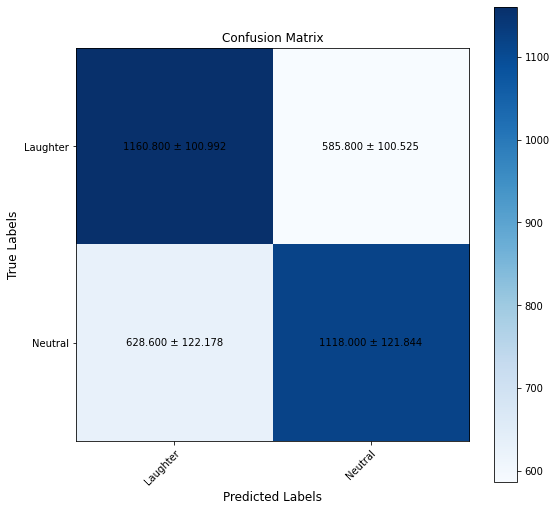

In [0]:
mean_confusions = np.mean(np.array(conf_matrices), axis = 0)
std_confusions = np.std(np.array(conf_matrices), axis = 0)

label_names = ["Laughter", "Neutral"]

fig, ax = plt.subplots(figsize = (8, 8))
im = ax.imshow(mean_confusions, cmap = "Blues")

# We want to show all ticks...
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.xlabel("Predicted Labels", fontsize = 'large')
plt.ylabel("True Labels", fontsize = 'large')
# Loop over data dimensions and create text annotations.
for i in range(len(label_names)):
    for j in range(len(label_names)):
        text = ax.text(j, i, f'{mean_confusions[i, j]:.3f} ± {std_confusions[i, j]:.3f}',
                       ha="center", va="center", color="black")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.colorbar(im)
plt.show()